In [ ]:
using Plots, Roots, Optim, StatsBase, LinearAlgebra, Statistics, Random; Random.seed!(97)

struct Normal
    μ::Vector
    Σ::Array
end
struct Fruit
    value::Vector
    color::String
end

In [ ]:
# density function for the normal distribution N
f(x,N::Normal) = 1/(2π*sqrt(det(N.Σ))) * exp(-1/2*((x-N.μ)'*inv(N.Σ)*(x-N.μ)))
#initializing point values and weights
xs = 0:1/2^4:40
ys = 0:1/2^4:50
As = [[1.5 -1; 0 1],[1/2 1/4; 0 1/2]]
μs = [[7,36.5],[6,35]]
Ns = [Normal(μ,A*A') for (μ,A) in zip(μs,As)]
p = Weights([3/8,5/8])
color = ["red","green"]

In [ ]:
function randcolor(μs,As)
    i = sample(p)
    Fruit(As[i]*randn(2)+μs[i],color[i])
end

fruit = [randcolor(μs,As) for i=1:20]

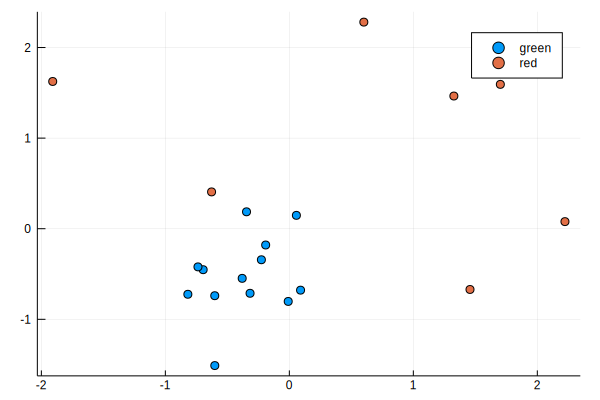

In [1]:
#assigning means and stds
mean_x = mean(Fruit.value[1] for Fruit in fruit)
std_x =  sqrt(var(Fruit.value[1] for Fruit in fruit))
mean_y = mean(Fruit.value[2] for Fruit in fruit)
std_y =  sqrt(var(Fruit.value[2] for Fruit in fruit))

#normalizing values
normalized_xs = [(Fruit.value[1] - mean_x)/std_x for Fruit in fruit]
normalized_ys = [(Fruit.value[2] - mean_y)/std_y for Fruit in fruit]
classes = [fruit[i].color for i = 1:length(fruit)]
stdized_fruit = [Fruit([normalized_xs[i], normalized_ys[i]],classes[i]) for i = 1:length(fruit)]
scatter(normalized_xs, normalized_ys, group = classes)

In [2]:
class_green = [[[Fruit.value[1], Fruit.value[2]], -1] for Fruit in stdized_fruit if Fruit.color == "green"]
class_red = [[[Fruit.value[1], Fruit.value[2]], 1] for Fruit in stdized_fruit if Fruit.color == "red"]
                        
all_classes = [class_green; class_red]

D(u) = abs(u) < 1 ? 70/81*(1-abs(u)^3)^3 : 0 # tri-cube function
D(λ,u) = 1/λ*D(u/λ) # scaled tri-cube
K(λ,x,y) = D(λ,x) * D(λ,y) # kernel
kde(λ,x,y,samples) = sum(K(λ,x-Xi,y-Yi) for (Xi,Yi) in samples)/length(samples)

#kde function
function kdeCV(λ,i,samples)
    x,y = samples[i]
    newsamples = copy(samples)
    deleteat!(newsamples,i)
    kde(λ,x,y,newsamples)
end

kdeCV (generic function with 1 method)

In [3]:
green_values =  [(x_1, x_2) for ((x_1, x_2), y) in class_green]
red_values = [(x_1, x_2) for ((x_1, x_2), y) in class_red]
all_values = [green_values; red_values]

J(λ, values) = sum([kde(λ,x,y,values)^2 for x=xs,y=ys])*step(xs)*step(ys) -
                2/length(values)*sum(kdeCV(λ,i,values) for i=1:length(values))

#λ_best_green = optimize(λ->J(first(λ), green_values),[1.0],BFGS()).minimizer
#λ_best_red = optimize(λ->J(first(λ), red_values),[1.0],BFGS()).minimizer
#lambdas = [λ_best_green λ_best_red]
lambdas = [0.104212  0.598711]

sum(K(1,1-Xi,2-Yi) for (Xi,Yi) in green_values)/length(green_values)

function L(λ,β,α,lambdas) 
    green_penalty = λ*norm(β)^2 + 1/length(class_green)*sum(max(0,1-y*(β⋅[x₁,x₂,x₁^2, x₂^2, x₁*x₂] - α))*length(class_green)*kde(lambdas[1], x₁, x₂, green_values) for ((x₁, x₂),y) in class_green)
    red_penalty = λ*norm(β)^2 + 1/length(class_red)*sum(max(0,1-y*(β⋅[x₁,x₂,x₁^2, x₂^2, x₁*x₂] - α))*length(class_red)*kde(lambdas[2], x₁, x₂, red_values) for ((x₁,x₂),y) in class_red)
    eventual_penalty = green_penalty + red_penalty
    eventual_penalty
end

L(λ,params,lambdas) = L(λ,params[1:length(params) - 1],params[end],lambdas)

L (generic function with 2 methods)

In [4]:
using Optim
function SVM(λ,samples)
    params = optimize(params->L(λ,params,lambdas),ones(6),BFGS()).minimizer
    #print("In iteration for Loss function\n ")
    params[1:end-1], params[end]
end

function CV(λ,samples,i)
    #print("In CV\n")
    β,α = SVM(λ,[samples[1:i-1];samples[i+1:end]])
    ((x₁,x₂),y) = samples[i]
    y*(β⋅[x₁,x₂,x₁^2, x₂^2, x₁*x₂] - α) < 0
end
function CV(λ,samples)
    mean(CV(λ,samples,i) for i=1:length(samples))
end

CV (generic function with 2 methods)

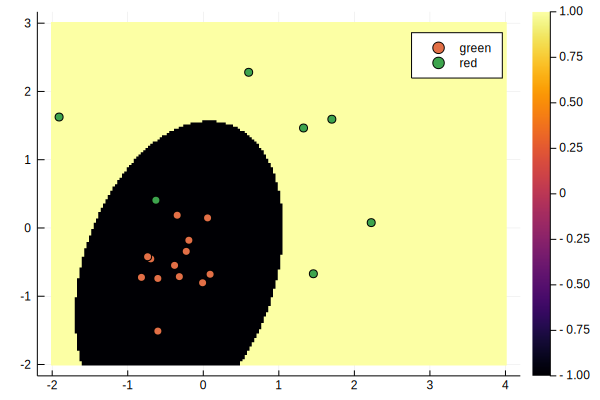

In [5]:
λ₁, λ₂ = 0.001, 0.25
λ = optimize(λ->CV(first(λ), all_classes), λ₁,λ₂).minimizer

β,α = SVM(λ,all_classes)

classify_svm(x_1, x_2) = β⋅[x_1, x_2, x_1^2, x_2^2, x_1*x_2] - α > 0 ? 1 : -1

x_steps = -2:1/2^5:4
y_steps = -2:1/2^5:3


heatmap(x_steps,y_steps, [classify_svm(x, y) for x = x_steps, y = y_steps], match_dimensions = true)
normalized_xs = [(Fruit.value[1] - mean_x)/std_x for Fruit in fruit]
normalized_ys = [(Fruit.value[2] - mean_y)/std_y for Fruit in fruit]
classes

scatter!(normalized_xs, normalized_ys, group = classes)